Importing Neccessary libraries

In [16]:
import pandas as pd
import os
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
import streamlit as st
import joblib
import matplotlib.pyplot as plt
from collections import Counter,  OrderedDict

Data Extraction and Cleaning

In [21]:
def remove_redundant_char(text):
    """gets Text as input and removes the redundant single and double charcter words
       returns the cleaned text"""
    out_text = []
    for i in word_tokenize(text):
        if len(i) > 2:
            out_text.append(i)
    out_text = " ".join(out_text)
    return out_text

In [22]:
en_stopwords = stopwords.words('english')
def file_extraction_cleaning(html_content):
    """Gets the content obtained from read_html function
       returns cleaned Text"""
    words_text = ""
    columns = html_content[0].shape[1] 
    for col in range(columns):                                          #For each column in the content                                   
        content = list(html_content[0][col])                        
        for i in content:                                           
            if isinstance(i, str):                                      #removing nan
                for word in word_tokenize(i):                              
                    words = re.findall(r'\b[a-zA-Z]+\b', word)          #removing numbers
                    if len(words) != 0 and words not in en_stopwords:   #removing empty strings and stopwords
                        words_text += ' ' + ' '.join(words)             #framing the text
    words_text = words_text.lower()                                     #converting the text to lowecase
    words_text = remove_redundant_char(words_text)                      #removing redundant characters
    return words_text

In [23]:
topics = os.listdir(r"data\data")                                                            
topics = topics[1:]
for topic in topics:                                                                        #For each topics
    # print(topic)
    text_list = []
    files = os.listdir(rf"data\data\{topic}")                                                #For each file in a topic
    files = files[1:]
    for file_name in files:
        # print(file_name)
        html_file_path = rf"data\data\{topic}\{file_name}"                                 
        html_content = pd.read_html(html_file_path)                                         #Reading the file
        words_text = file_extraction_cleaning(html_content)                                 #Text Extraction and Cleaning
        text_list.append({"doc_id":file_name[:-5], "doc_text":words_text, "topic":topic})   #Storing in a list
    topic_df =  pd.DataFrame(text_list)                                                     #Converting the list of dictionares to dataframe
    topic_df.to_csv(f"{topic}.csv")                                                         #Exporting the dataframe as csv

In [24]:
#Read and Combine the csv files to a single dataframe
bs = pd.read_csv("Balance Sheets.csv")
cf = pd.read_csv("Cash Flow.csv")
InS = pd.read_csv("Income Statement.csv")
Notes = pd.read_csv("Notes.csv")
Others = pd.read_csv("Others.csv") 

topic_df = pd.concat([bs, cf, InS, Notes, Others],ignore_index=True)
topic_df.head()


,Unnamed: 0,doc_id,doc_text,topic
0,0,18320959_3,particulars assets non current assets property...,Balance Sheets
1,1,18391125_2,particulars assets non current assets property...,Balance Sheets
2,2,18442877_5,particulars equity and liabilities shareholder...,Balance Sheets
3,3,18445487_2,gujarat narmada valley fertilizers chemicals l...,Balance Sheets
4,4,18445494_3,particulars equity and liabilities shareholder...,Balance Sheets


In [25]:
topic_df = topic_df.drop("Unnamed: 0", axis=1) #Dropping the Unnamed Column

In [26]:
topic_df.isnull().sum()                        #Checking for null values

doc_id       0
doc_text    47
topic        0
dtype: int64

In [27]:
topic_df = topic_df.dropna()                  #Dropping null valued rows

In [28]:
def remove_stopwords(text):                     #Stopwords removal
  """Gets the text and returns it without stopwords"""
  en_stopwords = stopwords.words('english') + ["iii", "mar"]
  result = []
  for token in word_tokenize(text):
      if token not in en_stopwords:
          result.append(token)
  result = " ".join(result)
  return result

topic_df["doc_text"] = topic_df["doc_text"].apply(remove_stopwords)

In [29]:
topic_df["doc_text"]

0       particulars assets non current assets property...
1       particulars assets non current assets property...
2       particulars equity liabilities shareholders fu...
3       gujarat narmada valley fertilizers chemicals l...
4       particulars equity liabilities shareholders fu...
                              ...                        
2519    singhi chartered accountants sarat bose road k...
2520    singhi chartered accountants sarat bose road k...
2521    steel authority india limited cin registered o...
2522    particulars particulars income operations prof...
2523    particulars gain deemed disposal dccdl group r...
Name: doc_text, Length: 2477, dtype: object

Proportion of each category in Dataset

<Axes: ylabel='count'>

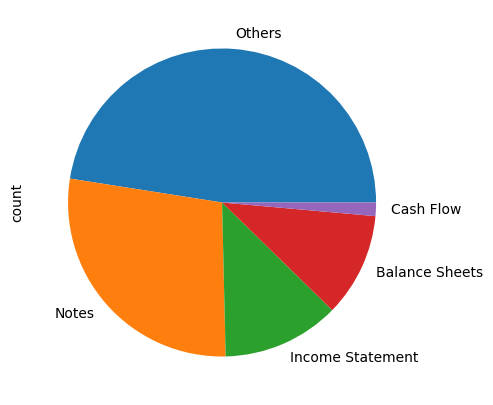

In [137]:
topic_df.topic.value_counts().plot(kind='pie', figsize=(5,5))

In [30]:
balance_words = []
for i in topic_df["doc_text"].loc[topic_df["topic"] == "Balance Sheets"]:
    balance_words.extend(word_tokenize(i))
cashflow_words = []
for i in topic_df["doc_text"].loc[topic_df["topic"] == "Cash Flow"]:
    cashflow_words.extend(word_tokenize(i))
Income_Statement_words = []
for i in topic_df["doc_text"].loc[topic_df["topic"] == "Income Statement"]:
    Income_Statement_words.extend(word_tokenize(i))
notes_words = []
for i in topic_df["doc_text"].loc[topic_df["topic"] == "Notes"]:
    notes_words.extend(word_tokenize(i))
other_words = []
for i in topic_df["doc_text"].loc[topic_df["topic"] == "Others"]:
    other_words.extend(word_tokenize(i))

In [31]:
top_balance_words = Counter(balance_words)
top_balance_words = dict(sorted(top_balance_words.items(), key=lambda kv: (kv[1], kv[0]), reverse = True)[:25])
top_cashflow_words = Counter(cashflow_words)
top_cashflow_words = dict(sorted(top_cashflow_words.items(), key=lambda kv: (kv[1], kv[0]), reverse = True)[:25])
top_Income_Statement_words = Counter(Income_Statement_words)
top_Income_Statement_words = dict(sorted(top_Income_Statement_words.items(), key=lambda kv: (kv[1], kv[0]), reverse = True)[:25])
top_notes_words = Counter(notes_words)
top_notes_words = dict(sorted(top_notes_words.items(), key=lambda kv: (kv[1], kv[0]), reverse = True)[:25])
top_other_words = Counter(other_words)
top_other_words = dict(sorted(top_other_words.items(), key=lambda kv: (kv[1], kv[0]), reverse = True)[:25])

Lets view the top 25 words of each category

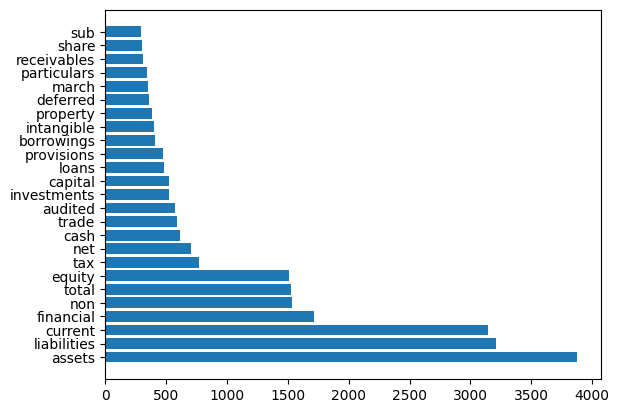

In [32]:
%matplotlib inline
# plt.subplot(3,2,1)
plt.barh(top_balance_words.keys(), top_balance_words.values())
plt.show()

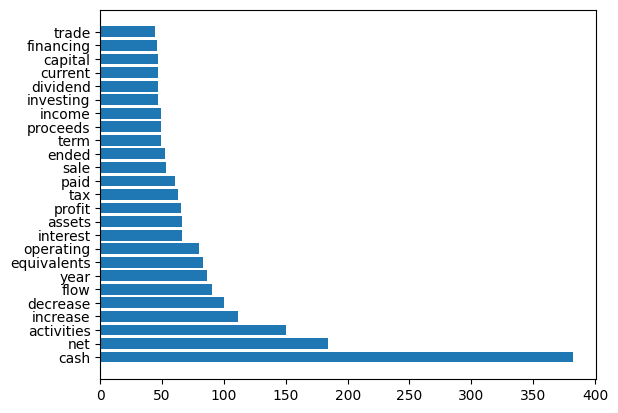

In [33]:
%matplotlib inline
# plt.subplot(3,2,1)
plt.barh(top_cashflow_words.keys(), top_cashflow_words.values())
plt.show()

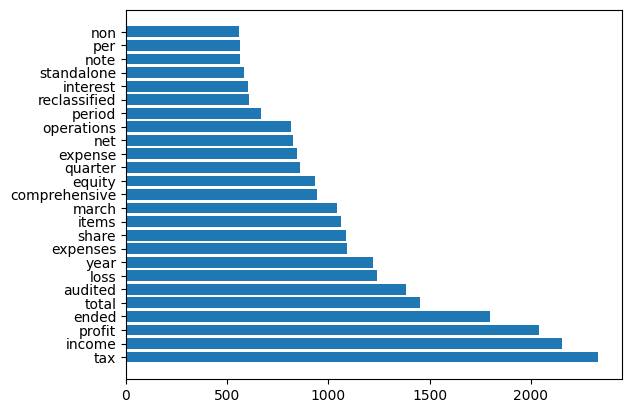

In [34]:
%matplotlib inline
plt.barh(top_Income_Statement_words.keys(), top_Income_Statement_words.values())
plt.show()

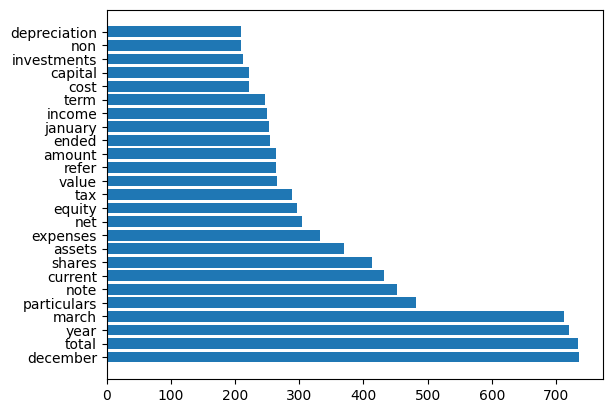

In [35]:
%matplotlib inline
plt.barh(top_notes_words.keys(), top_notes_words.values())
plt.show()

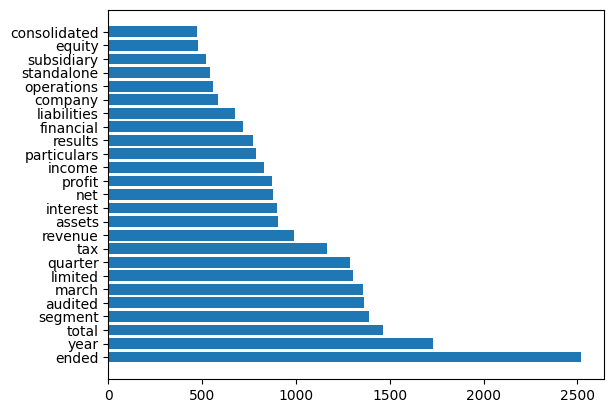

In [36]:
%matplotlib inline
plt.barh(top_other_words.keys(), top_other_words.values())
plt.show()

Vectorization

In [37]:
#Tf-idf Vectorizer helps us to give priority to important words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(topic_df['doc_text'])  #Vectorizing the text using tf-idf vectorizer
y = topic_df["topic"]

Model Building

Model 1: Multinomial Naive Bayes Classifier

In [38]:
skf = StratifiedKFold(n_splits=5)                               # Initialize stratified k-fold cross-validation

accuracy_scores = []                                            # Lists to store the results
f1_scores = []
classification_reports = []

for train_index, test_index in skf.split(X, y):                 # Perform stratified k-fold cross-validation
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = MultinomialNB()                                     # Train the Multinomial Naive Bayes model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)                              # Make predictions on the test set
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))      # Calculate accuracy and classification report
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True,zero_division=0))

print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")   # Print average accuracy
print(f"Average f1_score: {sum(f1_scores) / len(f1_scores):.4f}")

for i, report in enumerate(classification_reports):             # Print detailed classification report for each fold
    print(f"Fold {i + 1} Classification Report:")
    print(pd.DataFrame(report).transpose())

Average Accuracy: 0.8405
Average f1_score: 0.8337
Fold 1 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     0.962264  0.944444  0.953271   54.000000
Cash Flow          0.000000  0.000000  0.000000    7.000000
Income Statement   0.976744  0.688525  0.807692   61.000000
Notes              0.816000  0.739130  0.775665  138.000000
Others             0.785455  0.915254  0.845401  236.000000
accuracy           0.828629  0.828629  0.828629    0.828629
macro avg          0.708093  0.657471  0.676406  496.000000
weighted avg       0.825643  0.828629  0.821174  496.000000
Fold 2 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  0.962963  0.981132   54.000000
Cash Flow          0.000000  0.000000  0.000000    7.000000
Income Statement   0.912281  0.852459  0.881356   61.000000
Notes              0.881890  0.811594  0.845283  138.000000
Others             0.857692  0.944915  0.899194  2

Model 2: Support Vector Machine Classifier

In [39]:
skf = StratifiedKFold(n_splits=5)

# Lists to store the results
accuracy_scores = []
f1_scores = []
classification_reports = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Multinomial Naive Bayes model
    svm_model = LinearSVC()
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy and classification report
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Print average accuracy
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average f1_score: {sum(f1_scores) / len(f1_scores):.4f}")


# Print detailed classification report for each fold
for i, report in enumerate(classification_reports):
    print(f"Fold {i + 1} Classification Report:")
    print(pd.DataFrame(report).transpose())

Average Accuracy: 0.8781
Average f1_score: 0.8774
Fold 1 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     0.896552  0.962963  0.928571   54.000000
Cash Flow          0.857143  0.857143  0.857143    7.000000
Income Statement   0.958333  0.754098  0.844037   61.000000
Notes              0.840909  0.804348  0.822222  138.000000
Others             0.848606  0.902542  0.874743  236.000000
accuracy           0.862903  0.862903  0.862903    0.862903
macro avg          0.880309  0.856219  0.865343  496.000000
weighted avg       0.865299  0.862903  0.861966  496.000000
Fold 2 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  1.000000  1.000000   54.000000
Cash Flow          0.777778  1.000000  0.875000    7.000000
Income Statement   0.931034  0.885246  0.907563   61.000000
Notes              0.923077  0.869565  0.895522  138.000000
Others             0.906122  0.940678  0.923077  2

Model 3: Logistic Regression

In [40]:
skf = StratifiedKFold(n_splits=5)

# Lists to store the results
accuracy_scores = []
f1_scores = []
classification_reports = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Multinomial Naive Bayes model
    lg_model = LogisticRegression(max_iter=1000)
    lg_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lg_model.predict(X_test)

    # Calculate accuracy and classification report
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Print average accuracy
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average f1_score: {sum(f1_scores) / len(f1_scores):.4f}")


# Print detailed classification report for each fold
for i, report in enumerate(classification_reports):
    print(f"Fold {i + 1} Classification Report:")
    print(pd.DataFrame(report).transpose())

Average Accuracy: 0.8805
Average f1_score: 0.8796
Fold 1 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     0.962963  0.962963  0.962963   54.000000
Cash Flow          1.000000  0.714286  0.833333    7.000000
Income Statement   0.977273  0.704918  0.819048   61.000000
Notes              0.857143  0.782609  0.818182  138.000000
Others             0.816479  0.923729  0.866799  236.000000
accuracy           0.858871  0.858871  0.858871    0.858871
macro avg          0.922772  0.817701  0.860065  496.000000
weighted avg       0.866106  0.858871  0.857397  496.000000
Fold 2 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  0.981481  0.990654   54.000000
Cash Flow          1.000000  1.000000  1.000000    7.000000
Income Statement   0.947368  0.885246  0.915254   61.000000
Notes              0.943548  0.847826  0.893130  138.000000
Others             0.890196  0.961864  0.924644  2

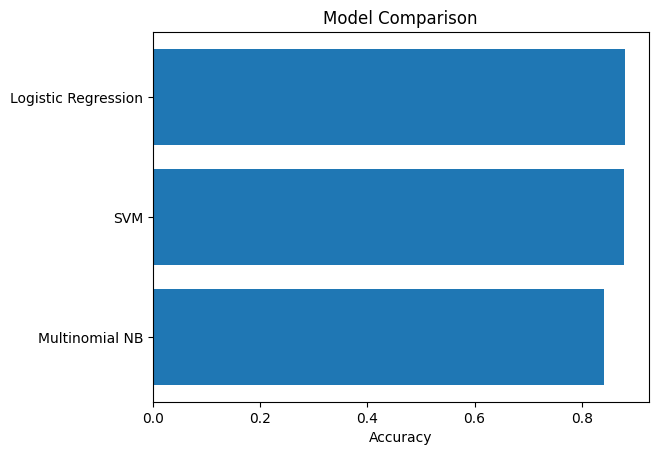

In [41]:
%matplotlib inline
models = {"Multinomial NB":0.8405, "SVM":0.8781, "Logistic Regression":0.8805}
plt.barh(models.keys(), models.values())

# Adding labels and title
plt.xlabel('Accuracy')
plt.title('Model Comparison')

# Display the plot
plt.show()

SVM and Logistic Regression gives the same accuracy but Logistic Regression is better than SVM by a small difference in accuracy.

Let's include the important words extracted from each document for modelling

In [42]:
topic_df_updated = topic_df.copy() #Create a copy of the original dataset to update

In [43]:
topic_df_updated["important_words"] = ""

In [44]:
for i in topic_df_updated.index:
    if topic_df_updated.loc[i,"topic"] == "Balance Sheets":
        topic_df_updated.loc[i,"important_words"] = " ".join(top_balance_words)
    if topic_df_updated.loc[i,"topic"] == "Cash Flow":
        topic_df_updated.loc[i,"important_words"] = " ".join(top_cashflow_words)
    if topic_df_updated.loc[i,"topic"] == "Income Statement":
        topic_df_updated.loc[i,"important_words"] = " ".join(top_Income_Statement_words)
    if topic_df_updated.loc[i,"topic"] == "Notes":
        topic_df_updated.loc[i,"important_words"] = " ".join(top_notes_words)
    if topic_df_updated.loc[i,"topic"] == "Others":
        topic_df_updated.loc[i,"important_words"] = " ".join(top_other_words)
    

In [45]:
topic_df_updated.head()

,doc_id,doc_text,topic,important_words
0,18320959_3,particulars assets non current assets property...,Balance Sheets,assets liabilities current financial non total...
1,18391125_2,particulars assets non current assets property...,Balance Sheets,assets liabilities current financial non total...
2,18442877_5,particulars equity liabilities shareholders fu...,Balance Sheets,assets liabilities current financial non total...
3,18445487_2,gujarat narmada valley fertilizers chemicals l...,Balance Sheets,assets liabilities current financial non total...
4,18445494_3,particulars equity liabilities shareholders fu...,Balance Sheets,assets liabilities current financial non total...


In [46]:
X_text = topic_df_updated['doc_text']  # Text feature
X_words = topic_df_updated['important_words']  # Important words feature
X_combined = X_text + ' ' + X_words  # Combine text and important words

In [47]:
X_combined

0       particulars assets non current assets property...
1       particulars assets non current assets property...
2       particulars equity liabilities shareholders fu...
3       gujarat narmada valley fertilizers chemicals l...
4       particulars equity liabilities shareholders fu...
                              ...                        
2519    singhi chartered accountants sarat bose road k...
2520    singhi chartered accountants sarat bose road k...
2521    steel authority india limited cin registered o...
2522    particulars particulars income operations prof...
2523    particulars gain deemed disposal dccdl group r...
Length: 2477, dtype: object

In [48]:
#Tf-idf Vectorizer helps us to give priority to important words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_combined)  #Vectorizing the text using tf-idf vectorizer
y = topic_df["topic"]

Model 1: Mutinomial Naive Bayes Classifier

In [50]:
skf = StratifiedKFold(n_splits=5)                               # Initialize stratified k-fold cross-validation

accuracy_scores = []                                            # Lists to store the results
f1_scores = []
classification_reports = []

for train_index, test_index in skf.split(X, y):                 # Perform stratified k-fold cross-validation
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = MultinomialNB()                                     # Train the Multinomial Naive Bayes model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)                              # Make predictions on the test set
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))      # Calculate accuracy and classification report
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True,zero_division=0))

print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")   # Print average accuracy
print(f"Average f1_score: {sum(f1_scores) / len(f1_scores):.4f}")

for i, report in enumerate(classification_reports):             # Print detailed classification report for each fold
    print(f"Fold {i + 1} Classification Report:")
    print(pd.DataFrame(report).transpose())

Average Accuracy: 0.9495
Average f1_score: 0.9426
Fold 1 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  0.962963  0.981132   54.000000
Cash Flow          0.000000  0.000000  0.000000    7.000000
Income Statement   1.000000  0.770492  0.870370   61.000000
Notes              0.910345  0.956522  0.932862  138.000000
Others             0.912698  0.974576  0.942623  236.000000
accuracy           0.929435  0.929435  0.929435    0.929435
macro avg          0.764609  0.732911  0.745398  496.000000
weighted avg       0.919404  0.929435  0.921911  496.000000
Fold 2 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  1.000000  1.000000   54.000000
Cash Flow          0.000000  0.000000  0.000000    7.000000
Income Statement   0.981481  0.868852  0.921739   61.000000
Notes              0.964539  0.985507  0.974910  138.000000
Others             0.947368  0.991525  0.968944  2

Model 2: Support Vector Classifier

In [51]:
skf = StratifiedKFold(n_splits=5)

# Lists to store the results
accuracy_scores = []
f1_scores = []
classification_reports = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Multinomial Naive Bayes model
    svm_model = LinearSVC()
    svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test)

    # Calculate accuracy and classification report
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Print average accuracy
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average f1_score: {sum(f1_scores) / len(f1_scores):.4f}")


# Print detailed classification report for each fold
for i, report in enumerate(classification_reports):
    print(f"Fold {i + 1} Classification Report:")
    print(pd.DataFrame(report).transpose())

Average Accuracy: 0.9871
Average f1_score: 0.9871
Fold 1 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  0.981481  0.990654   54.000000
Cash Flow          1.000000  1.000000  1.000000    7.000000
Income Statement   1.000000  0.950820  0.974790   61.000000
Notes              1.000000  0.978261  0.989011  138.000000
Others             0.971193  1.000000  0.985386  236.000000
accuracy           0.985887  0.985887  0.985887    0.985887
macro avg          0.994239  0.982112  0.987968  496.000000
weighted avg       0.986294  0.985887  0.985871  496.000000
Fold 2 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  1.000000  1.000000   54.000000
Cash Flow          1.000000  1.000000  1.000000    7.000000
Income Statement   1.000000  0.934426  0.966102   61.000000
Notes              1.000000  0.992754  0.996364  138.000000
Others             0.979253  1.000000  0.989518  2

Model 3: Logistic Regression Classifier

In [52]:
skf = StratifiedKFold(n_splits=5)

# Lists to store the results
accuracy_scores = []
f1_scores = []
classification_reports = []

# Perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Multinomial Naive Bayes model
    lg_model = LogisticRegression(max_iter=1000)
    lg_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lg_model.predict(X_test)

    # Calculate accuracy and classification report
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

# Print average accuracy
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average f1_score: {sum(f1_scores) / len(f1_scores):.4f}")


# Print detailed classification report for each fold
for i, report in enumerate(classification_reports):
    print(f"Fold {i + 1} Classification Report:")
    print(pd.DataFrame(report).transpose())

Average Accuracy: 0.9778
Average f1_score: 0.9776
Fold 1 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     0.980769  0.944444  0.962264   54.000000
Cash Flow          1.000000  0.857143  0.923077    7.000000
Income Statement   1.000000  0.836066  0.910714   61.000000
Notes              0.992593  0.971014  0.981685  138.000000
Others             0.932540  0.995763  0.963115  236.000000
accuracy           0.961694  0.961694  0.961694    0.961694
macro avg          0.981180  0.920886  0.948171  496.000000
weighted avg       0.963747  0.961694  0.961179  496.000000
Fold 2 Classification Report:
                  precision    recall  f1-score     support
Balance Sheets     1.000000  0.962963  0.981132   54.000000
Cash Flow          1.000000  1.000000  1.000000    7.000000
Income Statement   1.000000  0.901639  0.948276   61.000000
Notes              1.000000  0.985507  0.992701  138.000000
Others             0.959350  1.000000  0.979253  2

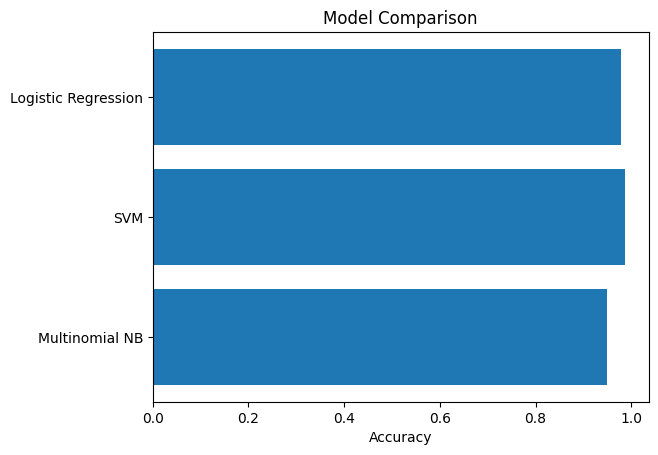

In [53]:
%matplotlib inline
models = {"Multinomial NB":0.9495, "SVM":0.9871, "Logistic Regression":0.9778}
plt.barh(models.keys(), models.values())

# Adding labels and title
plt.xlabel('Accuracy')
plt.title('Model Comparison')

# Display the plot
plt.show()

SVM Model has the highest accuracy, so let's save the model.

In [54]:
joblib.dump(svm_model, "svm_doc_classification.pkl")
joblib.dump(vectorizer, "TF_IDF_Vectorizer.pkl")

['TF_IDF_Vectorizer.pkl']